<a href="https://colab.research.google.com/github/idax6797/DeepLearning-MiniProject/blob/main/Notebooks/TransUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from typing import Tuple, Dict, List
from PIL import Image

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.7.1+cu118


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# TransUnet Architecture

In [3]:
class PatchEmbedding(nn.Module):
    """Split image into patches and embed them"""

    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_channels, embed_dim,
                             kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/P, W/P)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

In [4]:
class MultiHeadAttention(nn.Module):
    """Multi-head self-attention mechanism"""

    def __init__(self, embed_dim=768, num_heads=12, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)

        return x

In [5]:
class TransformerBlock(nn.Module):
    """Transformer encoder block"""

    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)

        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [6]:
class CNNEncoder(nn.Module):
    """CNN encoder for grayscale images"""

    def __init__(self, in_channels=1):
        super().__init__()

        # Custom encoder for grayscale images
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.conv3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.conv4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        features = []
        x = self.conv1(x)  # (B, 64, H/2, W/2)
        features.append(x)

        x = self.conv2(x)  # (B, 256, H/4, W/4)
        features.append(x)

        x = self.conv3(x)  # (B, 512, H/8, W/8)
        features.append(x)

        x = self.conv4(x)  # (B, 1024, H/16, W/16)
        features.append(x)

        return features

In [7]:
class DecoderBlock(nn.Module):
    """Decoder block with skip connections"""

    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels,
                                        kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels,
                     kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

In [8]:
class TransUNet(nn.Module):
    """TransUNet architecture for medical image segmentation"""

    def __init__(self, img_size=256, patch_size=16, in_channels=1,
                 num_classes=1, embed_dim=768, num_heads=12,
                 num_layers=12, mlp_ratio=4, dropout=0.1):
        super().__init__()

        # Validate that embed_dim is divisible by num_heads
        assert embed_dim % num_heads == 0, f"embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads})"

        # CNN Encoder
        self.cnn_encoder = CNNEncoder(in_channels=in_channels)

        # Patch embedding
        self.patch_embed = PatchEmbedding(
            img_size=img_size//16, patch_size=1,
            in_channels=1024, embed_dim=embed_dim
        )

        # Transformer encoder
        self.transformer = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)

        # Bridge to decoder
        self.conv_bridge = nn.Conv2d(embed_dim, 512, kernel_size=1)

        # Decoder
        self.decoder4 = DecoderBlock(512, 512, 256)
        self.decoder3 = DecoderBlock(256, 256, 128)
        self.decoder2 = DecoderBlock(128, 64, 64)
        self.decoder1 = DecoderBlock(64, 64, 32)
        # Upsample to original size
        self.final_upsample = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(64, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, num_classes, kernel_size=1)
        )

    def forward(self, x):
        # CNN encoder
        features = self.cnn_encoder(x)

        # Transformer encoder
        x_transformer = self.patch_embed(features[3])
        for block in self.transformer:
            x_transformer = block(x_transformer)
        x_transformer = self.norm(x_transformer)

        # Reshape transformer output
        B, N, C = x_transformer.shape
        H = W = int(N ** 0.5)
        x_transformer = x_transformer.transpose(1, 2).reshape(B, C, H, W)
        x_transformer = self.conv_bridge(x_transformer)

        # Decoder with skip connections
        x = self.decoder4(x_transformer, features[2]) # (16x16) -> (32x32) + features[2]
        x = self.decoder3(x, features[1]) # (32x32) -> (64x64) + features[1](64x64)
        x = self.decoder2(x, features[0]) # (64x64) -> (128x128) + features[0](128x128)

        # Upsample to original size
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)

        # Final output
        x = self.final(x)

        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [9]:
#Initialize model
transunet = TransUNet(img_size=256, patch_size=16, in_channels=1, num_classes=1, embed_dim=768, num_heads=12, num_layers=12, mlp_ratio=4, dropout=0.1).to(device)
num_params = transunet.count_parameters()
print(f"Number of trainable parameters in TransUNet: {num_params}")

Number of trainable parameters in TransUNet: 108156081


# Metrics and Loss Functions

In [10]:
def dice_coefficient(pred, target, threshold=0.5, epsilon=1e-7):
    """Compute Dice coefficient"""
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()

    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum()

    dice = (2.0 * intersection) / (union + epsilon)
    return dice.item()

In [11]:
def iou_score(pred, target, threshold=0.5, epsilon=1e-7):
    """Compute IoU (Intersection over Union)"""
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()

    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection

    iou = intersection / (union + epsilon)
    return iou.item()

In [12]:
class DiceLoss(nn.Module):
    """Dice loss for segmentation"""

    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)

        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

In [13]:
class CombinedLoss(nn.Module):
    """Combined BCE and Dice loss"""

    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice(pred, target)
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

# Training Setup

In [14]:
# Training configuration
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4

# Optimizer
optimizer = torch.optim.Adam(transunet.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Loss function: BCE for segmentation
#seg_criterion = nn.BCEWithLogitsLoss()

seg_criterion = CombinedLoss()

# Training history
history = {
    'train_loss': [],
    'train_dice': [],
    'train_iou': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
    'epoch_times': []
}

print("✓ Training configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Loss: Combined BCE + Dice")
print(f"  Metrics: Dice, IoU, BCE")
print(f"  Optimizer: Adam with weight decay={1e-5}")

✓ Training configuration:
  Epochs: 50
  Learning rate: 0.0001
  Loss: Combined BCE + Dice
  Metrics: Dice, IoU, BCE
  Optimizer: Adam with weight decay=1e-05


In [15]:
def train_epoch(model, dataloader, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    epoch_loss = []
    epoch_dice = []
    epoch_iou = []

    pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Train]")
    for images, masks, _ in pbar:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)

        #Compute Loss
        loss = seg_criterion(outputs, masks)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Compute metrics
        seg_probs = torch.sigmoid(outputs)
        dice = dice_coefficient(seg_probs, masks)
        iou = iou_score(seg_probs, masks)

        # Track metrics
        epoch_loss.append(loss.item())
        epoch_dice.append(dice)
        epoch_iou.append(iou)

        # Update progress
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'dice': f"{dice:.4f}",
            'iou': f"{iou:.4f}"
        })

    return {
        'loss': np.mean(epoch_loss),
        'dice': np.mean(epoch_dice),
        'iou': np.mean(epoch_iou)
    }

In [16]:
def validate_epoch(model, dataloader, epoch):
    model.eval()
    val_loss, val_dice, val_iou = [], [], []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Val]")
        for images, masks, _ in pbar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            if isinstance(outputs, list):
                losses = [seg_criterion(o, masks) for o in outputs]
                loss = sum(losses) / len(losses)
                seg_logits = outputs[-1]
            else:
                seg_logits = outputs
                loss = seg_criterion(seg_logits, masks)

            seg_probs = torch.sigmoid(seg_logits)
            dice = dice_coefficient(seg_probs, masks)
            iou = iou_score(seg_probs, masks)

            val_loss.append(loss.item())
            val_dice.append(dice)
            val_iou.append(iou)

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "dice": f"{dice:.4f}",
                "iou": f"{iou:.4f}"
            })

    return {
        "loss": np.mean(val_loss),
        "dice": np.mean(val_dice),
        "iou": np.mean(val_iou)
    }

# Load Data

In [17]:
class PreSplitTumorDataset(Dataset):
    """Dataset for loading pre-split train/val/test data"""
    def __init__(self, data_dir: str, split='train'):
        """
        Args:
            data_dir: Path to preprocessed_data directory
            split: 'train', 'val', or 'test'
        """
        self.data_dir = Path(data_dir) / split
        self.split = split

        print(f"\n{'='*70}")
        print(f"📂 Loading {split.upper()} dataset from: {self.data_dir}")
        print(f"{'='*70}")

        if not self.data_dir.exists():
            raise FileNotFoundError(f"Split directory not found: {self.data_dir}")

        self.samples = []

        control_dir = self.data_dir / 'controls' / 'imgs'
        patient_img_dir = self.data_dir / 'patients' / 'imgs'
        patient_label_dir = self.data_dir / 'patients' / 'labels'

        print(f"  Controls dir: {control_dir.exists()}")
        print(f"  Patients dir: {patient_img_dir.exists()}")
        print(f"  Labels dir: {patient_label_dir.exists()}")

        if control_dir.exists():
            control_files = sorted(list(control_dir.glob('*.png')))
            print(f"\n  Found {len(control_files)} control images")
            for img_path in control_files:
                self.samples.append((img_path, None, 0))

        if patient_img_dir.exists() and patient_label_dir.exists():
            patient_files = sorted(list(patient_img_dir.glob('*.png')))
            print(f"  Found {len(patient_files)} patient images")

            matched = 0
            for img_path in patient_files:
                img_stem = img_path.stem

                possible_label_names = [
                    img_path.name,
                    img_stem + '.png',
                    img_stem.replace('patient_', 'segmentation_') + '.png',
                ]

                label_path = None
                for label_name in possible_label_names:
                    test_path = patient_label_dir / label_name
                    if test_path.exists():
                        label_path = test_path
                        break

                if label_path:
                    self.samples.append((img_path, label_path, 1))
                    matched += 1

            print(f"  Matched {matched} patient images with labels")

        num_controls = len([s for s in self.samples if s[2] == 0])
        num_patients = len([s for s in self.samples if s[2] == 1])

        print(f"\n{'='*70}")
        print(f"📊 {split.upper()} SET SUMMARY")
        print(f"{'='*70}")
        print(f"  Controls: {num_controls}")
        print(f"  Patients: {num_patients}")
        print(f"  Total: {len(self.samples)}")
        print(f"  Tumor ratio: {num_patients/len(self.samples)*100:.1f}%")
        print(f"{'='*70}\n")

        if len(self.samples) == 0:
            raise ValueError(f"No samples found in {self.data_dir}")

    def __len__(self):
        return len(self.samples)

    def _load_image(self, path: Path) -> np.ndarray:
        """Load PNG image and convert to grayscale numpy array"""
        img = Image.open(path).convert('L')
        return np.array(img)

    def __getitem__(self, idx):
        img_path, label_path, has_tumor = self.samples[idx]

        image = self._load_image(img_path)

        if image.max() > 1.0:
            image = image / 255.0

        if label_path and label_path.exists():
            mask = self._load_image(label_path)
            if mask.max() > 1.0:
                mask = mask / 255.0
        else:
            mask = np.zeros_like(image)

        if image.ndim == 2:
            image = image[np.newaxis, ...]
        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]

        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).float()
        clf_label = torch.tensor(has_tumor, dtype=torch.long)

        return image, mask, clf_label


print("="*70)
print("🔍 LOADING PRE-SPLIT MIP-PET TUMOR DATASET")
print("="*70)

possible_paths = [
    Path('/Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/preprocessed_data'),
    Path('/work/IdaHayJørgensen#9284/Notebooks/preprocessed_data'),
    Path('/content/drive/MyDrive/preprocessed_data'),  # Colab path
]

DATA_DIR = None
for path in possible_paths:
    print(f"\n🔍 Checking: {path}")
    if path.exists():
        has_train = (path / 'train').exists()
        has_val = (path / 'val').exists()
        has_test = (path / 'test').exists()

        print(f"   Train folder: {has_train}")
        print(f"   Val folder: {has_val}")
        print(f"   Test folder: {has_test}")

        if has_train and has_val and has_test:
            DATA_DIR = path
            print(f"   ✅ Using this directory!")
            break
    else:
        print(f"   ❌ Directory doesn't exist")

if DATA_DIR is None:
    raise FileNotFoundError("Pre-split data directory not found! Please run EDA.ipynb first to create splits.")

print(f"\n{'='*70}")
print(f"📂 Final data directory: {DATA_DIR}")
print(f"{'='*70}\n")

train_dataset = PreSplitTumorDataset(str(DATA_DIR), split='train')
val_dataset = PreSplitTumorDataset(str(DATA_DIR), split='val')
test_dataset = PreSplitTumorDataset(str(DATA_DIR), split='test')

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n{'='*70}")
print(f"✅ DATALOADERS CREATED")
print(f"{'='*70}")
print(f"  Train batches: {len(train_loader)} ({len(train_dataset)} samples)")
print(f"  Val batches: {len(val_loader)} ({len(val_dataset)} samples)")
print(f"  Test batches: {len(test_loader)} ({len(test_dataset)} samples)")
print(f"{'='*70}\n")

🔍 LOADING PRE-SPLIT MIP-PET TUMOR DATASET

🔍 Checking: /Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/preprocessed_data
   ❌ Directory doesn't exist

🔍 Checking: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data
   Train folder: True
   Val folder: True
   Test folder: True
   ✅ Using this directory!

📂 Final data directory: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data


📂 Loading TRAIN dataset from: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data/train
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 298 control images
  Found 127 patient images
  Matched 127 patient images with labels

📊 TRAIN SET SUMMARY
  Controls: 298
  Patients: 127
  Total: 425
  Tumor ratio: 29.9%


📂 Loading VAL dataset from: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data/val
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 64 control images
  Found 27 patient images
  Matched 27 patient images with labels

📊 VA

# Train Model

In [18]:
import time
training_start = time.time()
best_val_dice = 0.0
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()

    # Train
    train_metrics = train_epoch(transunet, train_loader, optimizer, epoch)

    # Validate
    val_metrics = validate_epoch(transunet, val_loader, epoch)

    # Track history
    history['train_loss'].append(train_metrics['loss'])
    history['train_dice'].append(train_metrics['dice'])
    history['train_iou'].append(train_metrics['iou'])
    history['val_loss'].append(val_metrics['loss'])
    history['val_dice'].append(val_metrics['dice'])
    history['val_iou'].append(val_metrics['iou'])

    epoch_time = time.time() - epoch_start
    history['epoch_times'].append(epoch_time)

    # Print summary
    print(f"\nEpoch {epoch}/{NUM_EPOCHS} Summary:")
    print(f"  Train - Loss: {train_metrics['loss']:.4f}, Dice: {train_metrics['dice']:.4f}, IoU: {train_metrics['iou']:.4f}")
    print(f"  Val   - Loss: {val_metrics['loss']:.4f}, Dice: {val_metrics['dice']:.4f}, IoU: {val_metrics['iou']:.4f}")
    print(f"  Time: {epoch_time:.1f}s")

    # Save best model
    if val_metrics['dice'] > best_val_dice:
        best_val_dice = val_metrics['dice']
        torch.save(transunet.state_dict(), 'best_transunet_segmentation.pth')
        print(f"  ✓ New best model saved! (Dice: {best_val_dice:.4f})")

training_time = time.time() - training_start

print("\n" + "="*70)
print("🎓 SEGMENTATION TRAINING COMPLETE!")
print("="*70)
print(f"Total training time: {training_time:.1f}s ({training_time/60:.1f} minutes)")
print(f"Average epoch time: {np.mean(history['epoch_times']):.1f}s")
print(f"Best validation Dice: {best_val_dice:.4f}")

# Load best model
transunet.load_state_dict(torch.load('best_transunet_segmentation.pth'))
print("\n✓ Best model loaded for evaluation!")

Epoch 1 [Val]: 100%|██████████| 12/12 [00:01<00:00,  7.52it/s, loss=0.7806, dice=0.1442, iou=0.0777]



Epoch 1/50 Summary:
  Train - Loss: 0.8144, Dice: 0.0514, IoU: 0.0276
  Val   - Loss: 0.7867, Dice: 0.0414, IoU: 0.0221
  Time: 18.1s
  ✓ New best model saved! (Dice: 0.0414)


Epoch 2 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.21it/s, loss=0.7730, dice=0.2026, iou=0.1127]



Epoch 2/50 Summary:
  Train - Loss: 0.7738, Dice: 0.1089, IoU: 0.0611
  Val   - Loss: 0.7757, Dice: 0.0764, IoU: 0.0436
  Time: 17.3s
  ✓ New best model saved! (Dice: 0.0764)


Epoch 3 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.80it/s, loss=0.7624, dice=0.1809, iou=0.0995]



Epoch 3/50 Summary:
  Train - Loss: 0.7548, Dice: 0.2319, IoU: 0.1479
  Val   - Loss: 0.7569, Dice: 0.0842, IoU: 0.0490
  Time: 16.2s
  ✓ New best model saved! (Dice: 0.0842)


Epoch 4 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.17it/s, loss=0.7376, dice=0.1589, iou=0.0863]



Epoch 4/50 Summary:
  Train - Loss: 0.7427, Dice: 0.3029, IoU: 0.1949
  Val   - Loss: 0.7401, Dice: 0.0928, IoU: 0.0547
  Time: 17.4s
  ✓ New best model saved! (Dice: 0.0928)


Epoch 5 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.02it/s, loss=0.7303, dice=0.2005, iou=0.1114]



Epoch 5/50 Summary:
  Train - Loss: 0.7361, Dice: 0.3176, IoU: 0.2077
  Val   - Loss: 0.7328, Dice: 0.1185, IoU: 0.0739
  Time: 16.9s
  ✓ New best model saved! (Dice: 0.1185)


Epoch 6 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.36it/s, loss=0.7214, dice=0.2772, iou=0.1609]



Epoch 6/50 Summary:
  Train - Loss: 0.7309, Dice: 0.3548, IoU: 0.2415
  Val   - Loss: 0.7269, Dice: 0.1333, IoU: 0.0845
  Time: 16.3s
  ✓ New best model saved! (Dice: 0.1333)


Epoch 7 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.57it/s, loss=0.7171, dice=0.4855, iou=0.3206]



Epoch 7/50 Summary:
  Train - Loss: 0.7259, Dice: 0.4232, IoU: 0.2879
  Val   - Loss: 0.7245, Dice: 0.1591, IoU: 0.1065
  Time: 16.4s
  ✓ New best model saved! (Dice: 0.1591)


Epoch 8 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.14it/s, loss=0.7162, dice=0.2389, iou=0.1356]



Epoch 8/50 Summary:
  Train - Loss: 0.7215, Dice: 0.3927, IoU: 0.2739
  Val   - Loss: 0.7211, Dice: 0.1049, IoU: 0.0632
  Time: 16.3s


Epoch 9 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.18it/s, loss=0.7105, dice=0.4168, iou=0.2633]



Epoch 9/50 Summary:
  Train - Loss: 0.7172, Dice: 0.4610, IoU: 0.3262
  Val   - Loss: 0.7175, Dice: 0.1527, IoU: 0.0994
  Time: 16.2s


Epoch 10 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.33it/s, loss=0.6993, dice=0.5406, iou=0.3705]



Epoch 10/50 Summary:
  Train - Loss: 0.7131, Dice: 0.4536, IoU: 0.3226
  Val   - Loss: 0.7100, Dice: 0.1839, IoU: 0.1279
  Time: 16.2s
  ✓ New best model saved! (Dice: 0.1839)


Epoch 11 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.63it/s, loss=0.7017, dice=0.4456, iou=0.2867]



Epoch 11/50 Summary:
  Train - Loss: 0.7087, Dice: 0.5047, IoU: 0.3696
  Val   - Loss: 0.7086, Dice: 0.1701, IoU: 0.1156
  Time: 17.1s


Epoch 12 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.75it/s, loss=0.6943, dice=0.4793, iou=0.3152]



Epoch 12/50 Summary:
  Train - Loss: 0.7046, Dice: 0.5092, IoU: 0.3667
  Val   - Loss: 0.7016, Dice: 0.1619, IoU: 0.1107
  Time: 17.4s


Epoch 13 [Val]: 100%|██████████| 12/12 [00:01<00:00,  7.87it/s, loss=0.6977, dice=0.3795, iou=0.2342]



Epoch 13/50 Summary:
  Train - Loss: 0.7008, Dice: 0.5037, IoU: 0.3722
  Val   - Loss: 0.7040, Dice: 0.1617, IoU: 0.1087
  Time: 17.6s


Epoch 14 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.32it/s, loss=0.7011, dice=0.3517, iou=0.2134]



Epoch 14/50 Summary:
  Train - Loss: 0.6962, Dice: 0.5150, IoU: 0.3784
  Val   - Loss: 0.7056, Dice: 0.1458, IoU: 0.0949
  Time: 16.9s


Epoch 15 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.07it/s, loss=0.6861, dice=0.3155, iou=0.1873]



Epoch 15/50 Summary:
  Train - Loss: 0.6956, Dice: 0.4134, IoU: 0.2876
  Val   - Loss: 0.6926, Dice: 0.1376, IoU: 0.0902
  Time: 17.6s


Epoch 16 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.98it/s, loss=0.6786, dice=0.4749, iou=0.3114]



Epoch 16/50 Summary:
  Train - Loss: 0.6901, Dice: 0.4474, IoU: 0.3278
  Val   - Loss: 0.6871, Dice: 0.1833, IoU: 0.1277
  Time: 17.0s


Epoch 17 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.39it/s, loss=0.6944, dice=0.3309, iou=0.1982]



Epoch 17/50 Summary:
  Train - Loss: 0.6850, Dice: 0.5386, IoU: 0.4079
  Val   - Loss: 0.6946, Dice: 0.1422, IoU: 0.0919
  Time: 17.6s


Epoch 18 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.82it/s, loss=0.6762, dice=0.2667, iou=0.1538]



Epoch 18/50 Summary:
  Train - Loss: 0.6815, Dice: 0.5477, IoU: 0.4106
  Val   - Loss: 0.6817, Dice: 0.1030, IoU: 0.0635
  Time: 17.2s


Epoch 19 [Val]: 100%|██████████| 12/12 [00:01<00:00,  7.85it/s, loss=0.6676, dice=0.4611, iou=0.2997]



Epoch 19/50 Summary:
  Train - Loss: 0.6775, Dice: 0.5624, IoU: 0.4218
  Val   - Loss: 0.6785, Dice: 0.1778, IoU: 0.1228
  Time: 17.5s


Epoch 20 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.11it/s, loss=0.6646, dice=0.4458, iou=0.2869]



Epoch 20/50 Summary:
  Train - Loss: 0.6737, Dice: 0.5569, IoU: 0.4248
  Val   - Loss: 0.6736, Dice: 0.1862, IoU: 0.1312
  Time: 17.1s
  ✓ New best model saved! (Dice: 0.1862)


Epoch 21 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.43it/s, loss=0.6636, dice=0.4511, iou=0.2912]



Epoch 21/50 Summary:
  Train - Loss: 0.6696, Dice: 0.5562, IoU: 0.4215
  Val   - Loss: 0.6720, Dice: 0.1729, IoU: 0.1179
  Time: 17.2s


Epoch 22 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.26it/s, loss=0.6958, dice=0.3077, iou=0.1818]



Epoch 22/50 Summary:
  Train - Loss: 0.6666, Dice: 0.5602, IoU: 0.4227
  Val   - Loss: 0.6890, Dice: 0.1344, IoU: 0.0859
  Time: 17.0s


Epoch 23 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.56it/s, loss=0.6493, dice=0.5891, iou=0.4175]



Epoch 23/50 Summary:
  Train - Loss: 0.6630, Dice: 0.5723, IoU: 0.4406
  Val   - Loss: 0.6609, Dice: 0.1985, IoU: 0.1438
  Time: 17.1s
  ✓ New best model saved! (Dice: 0.1985)


Epoch 24 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.77it/s, loss=0.6488, dice=0.4734, iou=0.3101]



Epoch 24/50 Summary:
  Train - Loss: 0.6586, Dice: 0.6152, IoU: 0.4854
  Val   - Loss: 0.6586, Dice: 0.1741, IoU: 0.1197
  Time: 17.4s


Epoch 25 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.94it/s, loss=0.6498, dice=0.3076, iou=0.1818]



Epoch 25/50 Summary:
  Train - Loss: 0.6554, Dice: 0.5820, IoU: 0.4538
  Val   - Loss: 0.6563, Dice: 0.1332, IoU: 0.0858
  Time: 17.3s


Epoch 26 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.55it/s, loss=0.6397, dice=0.5132, iou=0.3452]



Epoch 26/50 Summary:
  Train - Loss: 0.6502, Dice: 0.6225, IoU: 0.4898
  Val   - Loss: 0.6515, Dice: 0.1938, IoU: 0.1384
  Time: 17.4s


Epoch 27 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.46it/s, loss=0.6342, dice=0.5519, iou=0.3812]



Epoch 27/50 Summary:
  Train - Loss: 0.6485, Dice: 0.5949, IoU: 0.4645
  Val   - Loss: 0.6485, Dice: 0.1774, IoU: 0.1232
  Time: 17.5s


Epoch 28 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.78it/s, loss=0.6303, dice=0.6432, iou=0.4740]



Epoch 28/50 Summary:
  Train - Loss: 0.6449, Dice: 0.6064, IoU: 0.4743
  Val   - Loss: 0.6451, Dice: 0.1973, IoU: 0.1423
  Time: 17.4s


Epoch 29 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.39it/s, loss=0.6297, dice=0.5047, iou=0.3376]



Epoch 29/50 Summary:
  Train - Loss: 0.6408, Dice: 0.6245, IoU: 0.4935
  Val   - Loss: 0.6416, Dice: 0.1876, IoU: 0.1331
  Time: 16.3s


Epoch 30 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.72it/s, loss=0.6232, dice=0.5798, iou=0.4082]



Epoch 30/50 Summary:
  Train - Loss: 0.6377, Dice: 0.5957, IoU: 0.4679
  Val   - Loss: 0.6381, Dice: 0.1918, IoU: 0.1366
  Time: 17.0s


Epoch 31 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.87it/s, loss=0.6412, dice=0.3970, iou=0.2477]



Epoch 31/50 Summary:
  Train - Loss: 0.6340, Dice: 0.7151, IoU: 0.5726
  Val   - Loss: 0.6424, Dice: 0.1717, IoU: 0.1177
  Time: 16.7s


Epoch 32 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.09it/s, loss=0.6407, dice=0.3847, iou=0.2382]



Epoch 32/50 Summary:
  Train - Loss: 0.6299, Dice: 0.6261, IoU: 0.5022
  Val   - Loss: 0.6466, Dice: 0.1666, IoU: 0.1130
  Time: 17.3s


Epoch 33 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.05it/s, loss=0.6500, dice=0.2721, iou=0.1574]



Epoch 33/50 Summary:
  Train - Loss: 0.6341, Dice: 0.3451, IoU: 0.2359
  Val   - Loss: 0.6603, Dice: 0.1047, IoU: 0.0628
  Time: 17.3s


Epoch 34 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.76it/s, loss=0.6123, dice=0.5048, iou=0.3376]



Epoch 34/50 Summary:
  Train - Loss: 0.6277, Dice: 0.4777, IoU: 0.3443
  Val   - Loss: 0.6282, Dice: 0.1964, IoU: 0.1407
  Time: 17.4s


Epoch 35 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.04it/s, loss=0.6252, dice=0.4008, iou=0.2506]



Epoch 35/50 Summary:
  Train - Loss: 0.6223, Dice: 0.6322, IoU: 0.4881
  Val   - Loss: 0.6299, Dice: 0.1643, IoU: 0.1108
  Time: 16.7s


Epoch 36 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.95it/s, loss=0.6031, dice=0.5765, iou=0.4050]



Epoch 36/50 Summary:
  Train - Loss: 0.6193, Dice: 0.6353, IoU: 0.4986
  Val   - Loss: 0.6192, Dice: 0.1878, IoU: 0.1334
  Time: 16.5s


Epoch 37 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.03it/s, loss=0.5964, dice=0.6373, iou=0.4676]



Epoch 37/50 Summary:
  Train - Loss: 0.6157, Dice: 0.5771, IoU: 0.4598
  Val   - Loss: 0.6162, Dice: 0.2069, IoU: 0.1519
  Time: 17.3s
  ✓ New best model saved! (Dice: 0.2069)


Epoch 38 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.86it/s, loss=0.5938, dice=0.5886, iou=0.4170]



Epoch 38/50 Summary:
  Train - Loss: 0.6126, Dice: 0.6598, IoU: 0.5319
  Val   - Loss: 0.6127, Dice: 0.1948, IoU: 0.1392
  Time: 17.0s


Epoch 39 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.44it/s, loss=0.6064, dice=0.3284, iou=0.1965]



Epoch 39/50 Summary:
  Train - Loss: 0.6095, Dice: 0.6558, IoU: 0.5257
  Val   - Loss: 0.6135, Dice: 0.1148, IoU: 0.0700
  Time: 16.9s


Epoch 40 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.54it/s, loss=0.5979, dice=0.3243, iou=0.1935]



Epoch 40/50 Summary:
  Train - Loss: 0.6063, Dice: 0.6535, IoU: 0.5192
  Val   - Loss: 0.6073, Dice: 0.1096, IoU: 0.0674
  Time: 16.1s


Epoch 41 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.67it/s, loss=0.5898, dice=0.6249, iou=0.4544]



Epoch 41/50 Summary:
  Train - Loss: 0.6040, Dice: 0.5943, IoU: 0.4673
  Val   - Loss: 0.6072, Dice: 0.1968, IoU: 0.1419
  Time: 16.2s


Epoch 42 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.55it/s, loss=0.5959, dice=0.3604, iou=0.2198]



Epoch 42/50 Summary:
  Train - Loss: 0.6009, Dice: 0.6295, IoU: 0.5049
  Val   - Loss: 0.6044, Dice: 0.1586, IoU: 0.1077
  Time: 16.1s


Epoch 43 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.87it/s, loss=0.5844, dice=0.5821, iou=0.4105]



Epoch 43/50 Summary:
  Train - Loss: 0.5982, Dice: 0.6113, IoU: 0.4821
  Val   - Loss: 0.6004, Dice: 0.2052, IoU: 0.1488
  Time: 17.0s


Epoch 44 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.03it/s, loss=0.5744, dice=0.6092, iou=0.4380]



Epoch 44/50 Summary:
  Train - Loss: 0.5943, Dice: 0.6845, IoU: 0.5532
  Val   - Loss: 0.5951, Dice: 0.2057, IoU: 0.1502
  Time: 17.2s


Epoch 45 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.41it/s, loss=0.5692, dice=0.5909, iou=0.4194]



Epoch 45/50 Summary:
  Train - Loss: 0.5919, Dice: 0.6961, IoU: 0.5674
  Val   - Loss: 0.5921, Dice: 0.2046, IoU: 0.1492
  Time: 17.5s


Epoch 46 [Val]: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s, loss=0.5683, dice=0.6331, iou=0.4632]



Epoch 46/50 Summary:
  Train - Loss: 0.5887, Dice: 0.7645, IoU: 0.6342
  Val   - Loss: 0.5901, Dice: 0.1925, IoU: 0.1400
  Time: 33.9s


Epoch 47 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.39it/s, loss=0.5641, dice=0.6789, iou=0.5139]



Epoch 47/50 Summary:
  Train - Loss: 0.5863, Dice: 0.7156, IoU: 0.5889
  Val   - Loss: 0.5866, Dice: 0.1997, IoU: 0.1465
  Time: 21.5s


Epoch 48 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.65it/s, loss=0.5644, dice=0.5694, iou=0.3980]



Epoch 48/50 Summary:
  Train - Loss: 0.5837, Dice: 0.6832, IoU: 0.5583
  Val   - Loss: 0.5850, Dice: 0.1974, IoU: 0.1416
  Time: 17.5s


Epoch 49 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.21it/s, loss=0.5573, dice=0.6406, iou=0.4712]



Epoch 49/50 Summary:
  Train - Loss: 0.5806, Dice: 0.7459, IoU: 0.6201
  Val   - Loss: 0.5828, Dice: 0.2071, IoU: 0.1531
  Time: 17.5s
  ✓ New best model saved! (Dice: 0.2071)


Epoch 50 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.74it/s, loss=0.5621, dice=0.5149, iou=0.3467]



Epoch 50/50 Summary:
  Train - Loss: 0.5757, Dice: 0.7345, IoU: 0.6168
  Val   - Loss: 0.5805, Dice: 0.1983, IoU: 0.1427
  Time: 16.3s

🎓 SEGMENTATION TRAINING COMPLETE!
Total training time: 880.3s (14.7 minutes)
Average epoch time: 17.4s
Best validation Dice: 0.2071

✓ Best model loaded for evaluation!


# Visualization

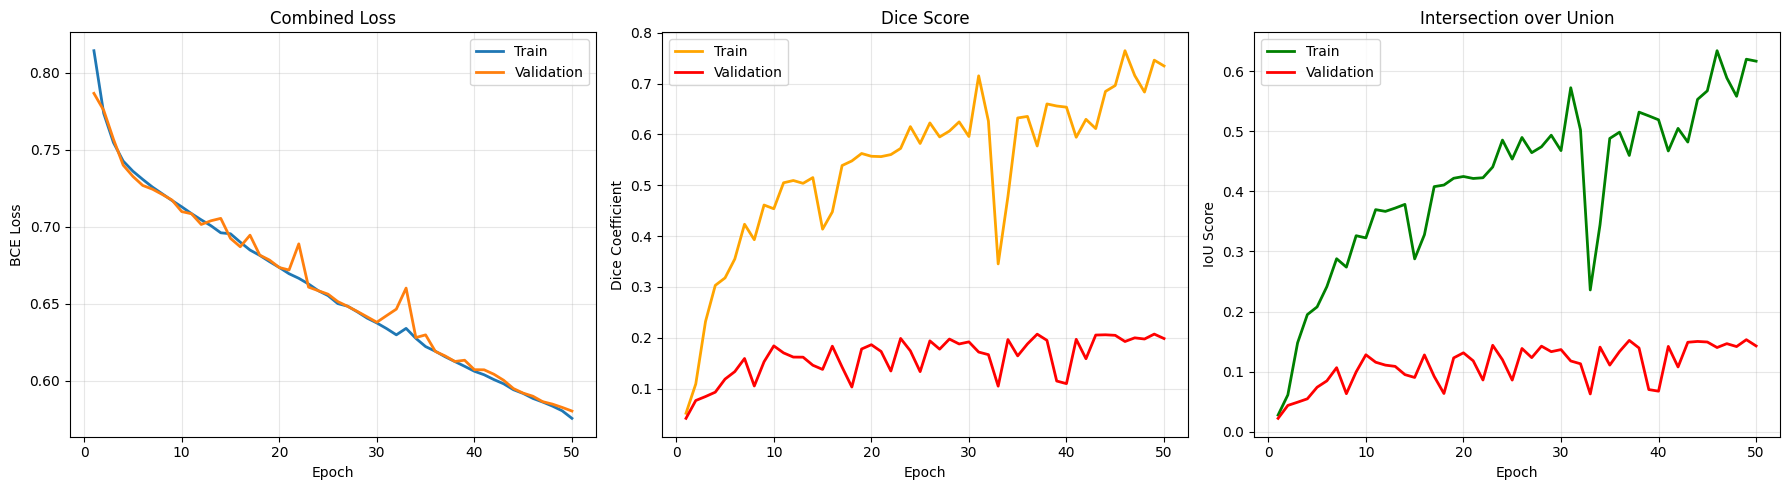

In [19]:
def plot_training_curves(history):
    """Plot training and validation curves"""
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # BCE Loss
    axes[0].plot(epochs, history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('BCE Loss')
    axes[0].set_title('Combined Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Dice Score
    axes[1].plot(epochs, history['train_dice'], label='Train', linewidth=2, color='orange')
    axes[1].plot(epochs, history['val_dice'], label='Validation', linewidth=2, color='red')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Coefficient')
    axes[1].set_title('Dice Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # IoU Score
    axes[2].plot(epochs, history['train_iou'], label='Train', linewidth=2, color='green')
    axes[2].plot(epochs, history['val_iou'], label='Validation', linewidth=2, color='red')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('IoU Score')
    axes[2].set_title('Intersection over Union')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_curves(history)

# Classification from Segmentation Masks

In [20]:
def classify_from_mask(mask_pred, mask_true, threshold=0.5, epsilon=1e-7):

    pred_binary = (mask_pred > threshold).float()
    true_binary = (mask_true > threshold).float()

    # Compute Dice coefficient
    intersection = (pred_binary * true_binary).sum().item()
    pred_sum = pred_binary.sum().item()  # Count of pixels with value 1
    true_sum = true_binary.sum().item()

    dice = (2.0 * intersection) / (pred_sum + true_sum + epsilon)

    # Compute IoU
    union = pred_sum + true_sum - intersection
    iou = intersection / (union + epsilon)


    predicted_class = 1 if pred_sum > 0 else 0

    return predicted_class, dice, iou

In [21]:
def evaluate_segmentation_and_classification(model, dataloader, split_name="Test"):
    """
    Evaluate both segmentation and classification.
    Classification is derived from segmentation quality (Dice/IoU scores).
    """
    model.eval()

    # Segmentation metrics
    all_seg_preds = []
    all_seg_true = []

    # Classification metrics
    all_clf_preds = []
    all_clf_true = []

    # Per-sample metrics for analysis
    all_dice_scores = []
    all_iou_scores = []

    print("\n" + "="*70)
    print(f"🔍 EVALUATING ON {split_name.upper()} SET")
    print("="*70)
    print("Classification based on: Segmentation probabilities [0, 1] from sigmoid")
    print("Metrics computed: Dice & IoU for each sample\n")

    with torch.no_grad():
        for images, masks, clf_labels in tqdm(dataloader, desc=f"Evaluating {split_name}"):
            images = images.to(device)

            # Stage 1: Segmentation
            seg_logits = model(images)
            seg_probs = torch.sigmoid(seg_logits)

            # Store segmentation predictions
            all_seg_preds.append(seg_probs.cpu())
            all_seg_true.append(masks.cpu())

            # Stage 2: Classification from segmentation quality
            for i in range(seg_probs.size(0)):
                # Compute classification using Dice/IoU
                pred_label, dice, iou = classify_from_mask(
                    seg_probs[i].cpu(),
                    masks[i].cpu()
                )
                true_label = clf_labels[i].item()

                all_clf_preds.append(pred_label)
                all_clf_true.append(true_label)
                all_dice_scores.append(dice)
                all_iou_scores.append(iou)

    # Concatenate segmentation results
    seg_preds = torch.cat(all_seg_preds, dim=0)
    seg_true = torch.cat(all_seg_true, dim=0)

    # ===============================
    # SEGMENTATION METRICS
    # ===============================
    pred_binary = (seg_preds > 0.5).float()
    true_binary = (seg_true > 0.5).float()

    pred_flat = pred_binary.view(-1)
    true_flat = true_binary.view(-1)

    TP = (pred_flat * true_flat).sum().item()
    FP = (pred_flat * (1 - true_flat)).sum().item()
    FN = ((1 - pred_flat) * true_flat).sum().item()
    TN = ((1 - pred_flat) * (1 - true_flat)).sum().item()

    epsilon = 1e-7

    iou = TP / (TP + FP + FN + epsilon)
    dice = (2 * TP) / (2 * TP + FP + FN + epsilon)
    pixel_acc = (TP + TN) / (TP + TN + FP + FN + epsilon)
    sensitivity = TP / (TP + FN + epsilon)
    specificity = TN / (TN + FP + epsilon)
    precision = TP / (TP + FP + epsilon)

    # Compute BCE loss
    bce_loss = seg_criterion(torch.logit(seg_preds.clamp(epsilon, 1-epsilon)), seg_true).item()

    seg_metrics = {
        'IoU': iou,
        'Dice': dice,
        'BCE_Loss': bce_loss,
        'Pixel_Accuracy': pixel_acc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision
    }

    print("\n" + "🎯 SEGMENTATION METRICS ".center(70, "="))
    print(f"  Dice Coefficient: {seg_metrics['Dice']:.4f}")
    print(f"  IoU Score: {seg_metrics['IoU']:.4f}")
    print(f"  BCE Loss: {seg_metrics['BCE_Loss']:.4f}")
    print(f"  Pixel Accuracy: {seg_metrics['Pixel_Accuracy']:.4f}")
    print(f"  Sensitivity (Recall): {seg_metrics['Sensitivity']:.4f}")
    print(f"  Specificity: {seg_metrics['Specificity']:.4f}")
    print(f"  Precision: {seg_metrics['Precision']:.4f}")

    # ===============================
    # CLASSIFICATION METRICS
    # ===============================
    all_clf_preds = np.array(all_clf_preds)
    all_clf_true = np.array(all_clf_true)
    all_dice_scores = np.array(all_dice_scores)
    all_iou_scores = np.array(all_iou_scores)

    # Confusion matrix
    TP_clf = np.sum((all_clf_preds == 1) & (all_clf_true == 1))
    TN_clf = np.sum((all_clf_preds == 0) & (all_clf_true == 0))
    FP_clf = np.sum((all_clf_preds == 1) & (all_clf_true == 0))
    FN_clf = np.sum((all_clf_preds == 0) & (all_clf_true == 1))

    cm = np.array([[TN_clf, FP_clf], [FN_clf, TP_clf]])

    accuracy = (TP_clf + TN_clf) / (TP_clf + TN_clf + FP_clf + FN_clf + epsilon)
    precision_clf = TP_clf / (TP_clf + FP_clf + epsilon)
    recall_clf = TP_clf / (TP_clf + FN_clf + epsilon)
    f1_score = 2 * (precision_clf * recall_clf) / (precision_clf + recall_clf + epsilon)

    # Average Dice/IoU for each classification outcome
    tp_indices = (all_clf_preds == 1) & (all_clf_true == 1)
    tn_indices = (all_clf_preds == 0) & (all_clf_true == 0)
    fp_indices = (all_clf_preds == 1) & (all_clf_true == 0)
    fn_indices = (all_clf_preds == 0) & (all_clf_true == 1)

    avg_dice_tp = all_dice_scores[tp_indices].mean() if tp_indices.sum() > 0 else 0
    avg_dice_tn = all_dice_scores[tn_indices].mean() if tn_indices.sum() > 0 else 0
    avg_dice_fp = all_dice_scores[fp_indices].mean() if fp_indices.sum() > 0 else 0
    avg_dice_fn = all_dice_scores[fn_indices].mean() if fn_indices.sum() > 0 else 0

    clf_metrics = {
        'Confusion_Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision_clf,
        'Recall': recall_clf,
        'F1_Score': f1_score,
        'Avg_Dice_TP': avg_dice_tp,
        'Avg_Dice_TN': avg_dice_tn,
        'Avg_Dice_FP': avg_dice_fp,
        'Avg_Dice_FN': avg_dice_fn,
        'Mean_Dice': all_dice_scores.mean(),
        'Mean_IoU': all_iou_scores.mean()
    }

    print("\n" + "🎯 CLASSIFICATION METRICS (from Seg Probs [0,1]) ".center(70, "="))
    print(f"  Accuracy: {clf_metrics['Accuracy']:.4f}")
    print(f"  Precision: {clf_metrics['Precision']:.4f}")
    print(f"  Recall: {clf_metrics['Recall']:.4f}")
    print(f"  F1-Score: {clf_metrics['F1_Score']:.4f}")
    print(f"\n  Per-Sample Metrics:")
    print(f"    Mean Dice: {clf_metrics['Mean_Dice']:.4f}")
    print(f"    Mean IoU: {clf_metrics['Mean_IoU']:.4f}")
    print(f"\n  Average Dice by Classification:")
    print(f"    True Positives (TP): {avg_dice_tp:.4f}")
    print(f"    True Negatives (TN): {avg_dice_tn:.4f}")
    print(f"    False Positives (FP): {avg_dice_fp:.4f}")
    print(f"    False Negatives (FN): {avg_dice_fn:.4f}")

    # Plot Confusion Matrix
    print("\n" + "📊 CONFUSION MATRIX ".center(70, "="))

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

    plt.colorbar(im, ax=ax)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No Tumor', 'Tumor'])
    ax.set_yticklabels(['No Tumor', 'Tumor'])

    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, int(cm[i, j]),
                          ha="center", va="center",
                          color="white" if cm[i, j] > cm.max()/2 else "black",
                          fontsize=16, fontweight='bold')

    ax.set_title(f"Classification from Segmentation Probabilities [0,1] ({split_name})\nAccuracy: {clf_metrics['Accuracy']:.3f} | Mean Dice: {clf_metrics['Mean_Dice']:.3f}",
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\n" + "="*70 + "\n")

    return seg_metrics, clf_metrics

# Show predictions

In [22]:
#Inspect what the loader yields
batch = next(iter(train_loader))
print(type(batch))
print(len(batch))

<class 'list'>
3


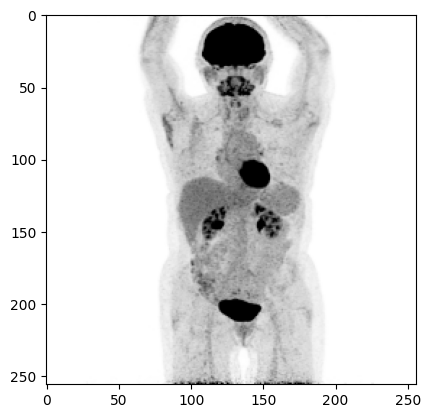

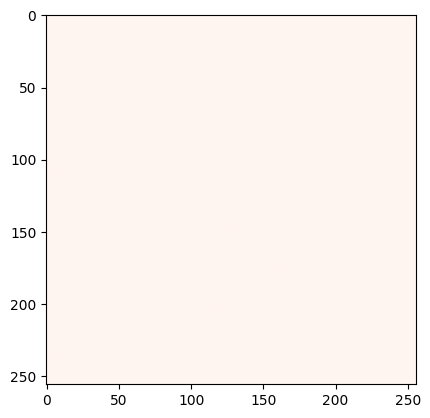

In [23]:
# Display image and label.
train_features, train_labels, _ = next(iter(train_loader))
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
plt.imshow(img, cmap="gray")
plt.show()
plt.imshow(label, cmap="Reds")
plt.show()
#print(f"Label: {label}")

In [24]:
def predict(model, image, device):
    model.eval()

    # Ensure correct shape
    if len(image.shape) == 2:
        image = image.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
    elif len(image.shape) == 3:
        image = image.unsqueeze(0)  # Add batch dim

    image = image.to(device)

    with torch.no_grad():
        output = model(image)

        # Get final output if deep supervision
        if isinstance(output, list):
            output = output[-1]

        # Get probabilities
        probs = torch.sigmoid(output)
        tumor_prob = probs
        pred_mask = (tumor_prob > 0.5).float()

    return pred_mask.squeeze().cpu(), tumor_prob.squeeze().cpu()

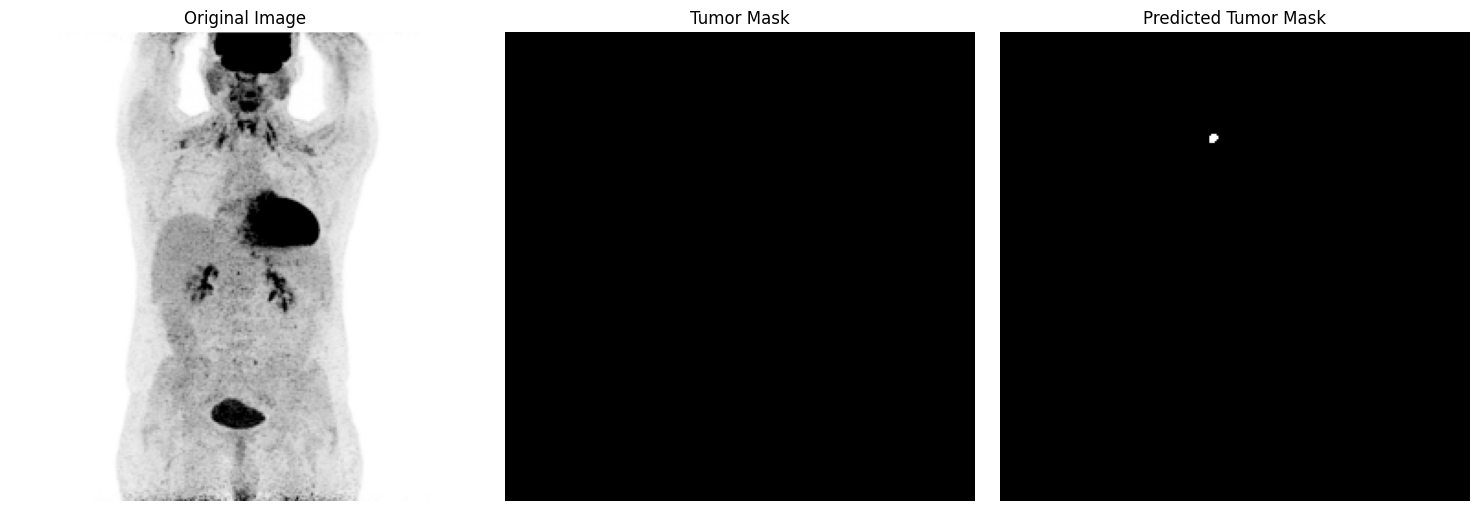

In [25]:
train_features, train_labels, _ = next(iter(train_loader))

pred_mask, _ = predict(transunet, train_features[0].squeeze(), device)

# Visualize prediction
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(train_features[0].squeeze(), cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(train_labels[0].squeeze(), cmap='gray')
axes[1].set_title('Tumor Mask')
axes[1].axis('off')

axes[2].imshow(pred_mask, cmap='gray')
axes[2].set_title('Predicted Tumor Mask')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('prediction_result.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
def classify_from_mask(mask_pred, mask_true, threshold=0.5, epsilon=1e-7):
    """
    Classify image based on segmentation probabilities [0, 1].

    Classification logic:
    - If ANY pixel >= threshold (0.5) in predicted mask → Tumor (1)
    - If NO pixels >= threshold → Healthy (0)

    Also computes Dice and IoU metrics for analysis.

    Args:
        mask_pred: Predicted segmentation probabilities [0, 1] (after sigmoid)
        mask_true: Ground truth mask [0, 1]
        threshold: Threshold for binarizing masks (default 0.5)
        epsilon: Small constant for numerical stability

    Returns:
        predicted_class: 1 if any tumor pixel detected, 0 otherwise
        dice_score: Dice coefficient for this prediction
        iou_score: IoU for this prediction
    """
    # Binarize masks at threshold 0.5
    # mask_pred already contains probabilities [0,1] from sigmoid
    # Pixels with prob ≥ 0.5 become 1, pixels < 0.5 become 0
    pred_binary = (mask_pred > threshold).float()
    true_binary = (mask_true > threshold).float()

    # Compute Dice coefficient
    intersection = (pred_binary * true_binary).sum().item()
    pred_sum = pred_binary.sum().item()  # Count of pixels with value 1
    true_sum = true_binary.sum().item()

    dice = (2.0 * intersection) / (pred_sum + true_sum + epsilon)

    # Compute IoU
    union = pred_sum + true_sum - intersection
    iou = intersection / (union + epsilon)

    # Classification: If ANY pixel == 1 (after thresholding) → Tumor
    # If ALL pixels == 0 → Healthy
    predicted_class = 1 if pred_sum > 0 else 0

    return predicted_class, dice, iou

In [29]:
def evaluate_segmentation_and_classification(model, dataloader, split_name="Test"):
    """
    Evaluate both segmentation and classification.
    Classification is derived from segmentation quality (Dice/IoU scores).
    """
    model.eval()

    # Segmentation metrics
    all_seg_preds = []
    all_seg_true = []

    # Classification metrics
    all_clf_preds = []
    all_clf_true = []

    # Per-sample metrics for analysis
    all_dice_scores = []
    all_iou_scores = []

    print("\n" + "="*70)
    print(f"🔍 EVALUATING ON {split_name.upper()} SET")
    print("="*70)
    print("Classification based on: Segmentation probabilities [0, 1] from sigmoid")
    print("Metrics computed: Dice & IoU for each sample\n")

    with torch.no_grad():
        for images, masks, clf_labels in tqdm(dataloader, desc=f"Evaluating {split_name}"):
            images = images.to(device)

            # Stage 1: Segmentation
            seg_logits = model(images)        # Raw outputs: [-∞, +∞]
            seg_probs = torch.sigmoid(seg_logits)  # Probabilities: [0, 1]

            # Store segmentation predictions
            all_seg_preds.append(seg_probs.cpu())
            all_seg_true.append(masks.cpu())

            # Stage 2: Classification from segmentation quality
            for i in range(seg_probs.size(0)):
                # Compute classification using Dice/IoU
                pred_label, dice, iou = classify_from_mask(
                    seg_probs[i].cpu(),
                    masks[i].cpu()
                )

                # pred_label, dice, iou = classify_from_mask_clean(
                #   seg_probs[i].cpu(),
                #   masks[i].cpu(),
                #   threshold=0.5)
                true_label = clf_labels[i].item()

                all_clf_preds.append(pred_label)
                all_clf_true.append(true_label)
                all_dice_scores.append(dice)
                all_iou_scores.append(iou)

    # Concatenate segmentation results
    seg_preds = torch.cat(all_seg_preds, dim=0)
    seg_true = torch.cat(all_seg_true, dim=0)

    # ===============================
    # SEGMENTATION METRICS
    # ===============================
    pred_binary = (seg_preds > 0.5).float()
    true_binary = (seg_true > 0.5).float()

    pred_flat = pred_binary.view(-1)
    true_flat = true_binary.view(-1)

    TP = (pred_flat * true_flat).sum().item()
    FP = (pred_flat * (1 - true_flat)).sum().item()
    FN = ((1 - pred_flat) * true_flat).sum().item()
    TN = ((1 - pred_flat) * (1 - true_flat)).sum().item()

    epsilon = 1e-7

    iou = TP / (TP + FP + FN + epsilon)
    dice = (2 * TP) / (2 * TP + FP + FN + epsilon)
    pixel_acc = (TP + TN) / (TP + TN + FP + FN + epsilon)
    sensitivity = TP / (TP + FN + epsilon)
    specificity = TN / (TN + FP + epsilon)
    precision = TP / (TP + FP + epsilon)

    # Compute BCE loss
    bce_loss = seg_criterion(torch.logit(seg_preds.clamp(epsilon, 1-epsilon)), seg_true).item()

    seg_metrics = {
        'IoU': iou,
        'Dice': dice,
        'BCE_Loss': bce_loss,
        'Pixel_Accuracy': pixel_acc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision
    }

    print("\n" + "🎯 SEGMENTATION METRICS ".center(70, "="))
    print(f"  Dice Coefficient: {seg_metrics['Dice']:.4f}")
    print(f"  IoU Score: {seg_metrics['IoU']:.4f}")
    print(f"  BCE Loss: {seg_metrics['BCE_Loss']:.4f}")
    print(f"  Pixel Accuracy: {seg_metrics['Pixel_Accuracy']:.4f}")
    print(f"  Sensitivity (Recall): {seg_metrics['Sensitivity']:.4f}")
    print(f"  Specificity: {seg_metrics['Specificity']:.4f}")
    print(f"  Precision: {seg_metrics['Precision']:.4f}")

    # ===============================
    # CLASSIFICATION METRICS
    # ===============================
    all_clf_preds = np.array(all_clf_preds)
    all_clf_true = np.array(all_clf_true)
    all_dice_scores = np.array(all_dice_scores)
    all_iou_scores = np.array(all_iou_scores)

    # Confusion matrix
    TP_clf = np.sum((all_clf_preds == 1) & (all_clf_true == 1))
    TN_clf = np.sum((all_clf_preds == 0) & (all_clf_true == 0))
    FP_clf = np.sum((all_clf_preds == 1) & (all_clf_true == 0))
    FN_clf = np.sum((all_clf_preds == 0) & (all_clf_true == 1))

    cm = np.array([[TN_clf, FP_clf], [FN_clf, TP_clf]])

    accuracy = (TP_clf + TN_clf) / (TP_clf + TN_clf + FP_clf + FN_clf + epsilon)
    precision_clf = TP_clf / (TP_clf + FP_clf + epsilon)
    recall_clf = TP_clf / (TP_clf + FN_clf + epsilon)
    f1_score = 2 * (precision_clf * recall_clf) / (precision_clf + recall_clf + epsilon)

    # Average Dice/IoU for each classification outcome
    tp_indices = (all_clf_preds == 1) & (all_clf_true == 1)
    tn_indices = (all_clf_preds == 0) & (all_clf_true == 0)
    fp_indices = (all_clf_preds == 1) & (all_clf_true == 0)
    fn_indices = (all_clf_preds == 0) & (all_clf_true == 1)

    avg_dice_tp = all_dice_scores[tp_indices].mean() if tp_indices.sum() > 0 else 0
    avg_dice_tn = all_dice_scores[tn_indices].mean() if tn_indices.sum() > 0 else 0
    avg_dice_fp = all_dice_scores[fp_indices].mean() if fp_indices.sum() > 0 else 0
    avg_dice_fn = all_dice_scores[fn_indices].mean() if fn_indices.sum() > 0 else 0

    clf_metrics = {
        'Confusion_Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision_clf,
        'Recall': recall_clf,
        'F1_Score': f1_score,
        'Avg_Dice_TP': avg_dice_tp,
        'Avg_Dice_TN': avg_dice_tn,
        'Avg_Dice_FP': avg_dice_fp,
        'Avg_Dice_FN': avg_dice_fn,
        'Mean_Dice': all_dice_scores.mean(),
        'Mean_IoU': all_iou_scores.mean()
    }

    print("\n" + "🎯 CLASSIFICATION METRICS (from Seg Probs [0,1]) ".center(70, "="))
    print(f"  Accuracy: {clf_metrics['Accuracy']:.4f}")
    print(f"  Precision: {clf_metrics['Precision']:.4f}")
    print(f"  Recall: {clf_metrics['Recall']:.4f}")
    print(f"  F1-Score: {clf_metrics['F1_Score']:.4f}")
    print(f"\n  Per-Sample Metrics:")
    print(f"    Mean Dice: {clf_metrics['Mean_Dice']:.4f}")
    print(f"    Mean IoU: {clf_metrics['Mean_IoU']:.4f}")
    print(f"\n  Average Dice by Classification:")
    print(f"    True Positives (TP): {avg_dice_tp:.4f}")
    print(f"    True Negatives (TN): {avg_dice_tn:.4f}")
    print(f"    False Positives (FP): {avg_dice_fp:.4f}")
    print(f"    False Negatives (FN): {avg_dice_fn:.4f}")

    # Plot Confusion Matrix
    print("\n" + "📊 CONFUSION MATRIX ".center(70, "="))

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

    plt.colorbar(im, ax=ax)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No Tumor', 'Tumor'])
    ax.set_yticklabels(['No Tumor', 'Tumor'])

    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, int(cm[i, j]),
                          ha="center", va="center",
                          color="white" if cm[i, j] > cm.max()/2 else "black",
                          fontsize=16, fontweight='bold')

    ax.set_title(f"Classification from Segmentation Probabilities [0,1] ({split_name})\nAccuracy: {clf_metrics['Accuracy']:.3f} | Mean Dice: {clf_metrics['Mean_Dice']:.3f}",
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\n" + "="*70 + "\n")

    return seg_metrics, clf_metrics


🔍 EVALUATING ON TEST SET
Classification based on: Segmentation probabilities [0, 1] from sigmoid
Metrics computed: Dice & IoU for each sample



Evaluating Test: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]



=======================🎯 SEGMENTATION METRICS ========================
  Dice Coefficient: 0.6235
  IoU Score: 0.4529
  BCE Loss: 0.5833
  Pixel Accuracy: 0.9968
  Sensitivity (Recall): 0.7433
  Specificity: 0.9977
  Precision: 0.5369

===========🎯 CLASSIFICATION METRICS (from Seg Probs [0,1]) ===========
  Accuracy: 0.6087
  Precision: 0.4333
  Recall: 0.9286
  F1-Score: 0.5909

  Per-Sample Metrics:
    Mean Dice: 0.2015
    Mean IoU: 0.1644

  Average Dice by Classification:
    True Positives (TP): 0.7129
    True Negatives (TN): 0.0000
    False Positives (FP): 0.0000
    False Negatives (FN): 0.0000

=========================📊 CONFUSION MATRIX ==========================


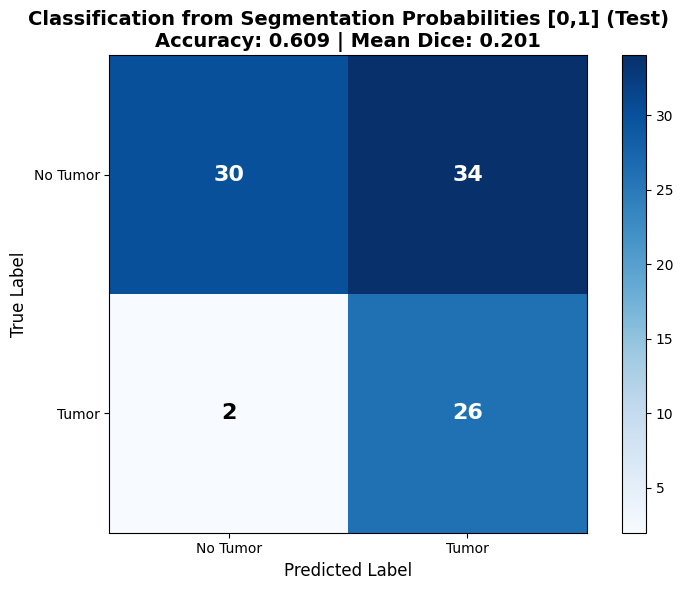

In [30]:
#Evaluate on test set
test_seg_metrics, test_clf_metrics = evaluate_segmentation_and_classification(
    transunet, test_loader, split_name="Test"
)